In [1]:
import numpy
import xray
from matplotlib import pyplot
import sys, os
import seaborn
import pandas
from mpl_toolkits.basemap import Basemap, cm
import scipy.stats
import itertools
import datetime


seaborn.set_style("whitegrid")
seaborn.set_context("paper",  font_scale=1.5)
#seaborn.set()

%matplotlib inline

/Users/tj/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [310]:
season = 'SON'
results_dir = "results-data/%s/" % season
results_files = [os.path.join(results_dir, f) for f in os.listdir(results_dir) if f[-3:] == ".nc"]
results_data = {os.path.basename(f).split("_")[0].upper(): xray.open_dataset(f) for f in results_files}
keys = ['BCSD', 'PCAOLS', 'PCAOLSNO', 'ELNET', 'ELNETNO',  'MSSL', 'BCSD-MSSL', 'CNN']
seasons = ['DJF', 'MAM', 'JJA', 'SON']



In [311]:
def truncate_projected(ds):
    proj = ds.projected.values.flatten()
    proj[proj < 0] = 0
    proj_truncated = proj.reshape(ds.projected.values.shape)
    dr = xray.DataArray(proj_truncated, coords=ds.projected.coords, 
                        dims=ds.projected.dims)
    ds['projected_truncated'] = dr / 10.
    ds['ground_truth'] = ds['ground_truth'] / 10.
    ds['error'] = ds['projected_truncated'] - ds['ground_truth']
    ds['RMSE'] = (ds.error**2).mean('time') ** 0.5
    ds['Bias'] = ds.error.mean('time')
    return ds


In [312]:
timeintersect = results_data[results_data.keys()[0]].time.values
for key in results_data.keys():
    if key[:4] == 'MSSL':
        msslkey = [k for k in results_data[key].variables.keys() if k[:4] == 'mssl']
        if len(msslkey) == 1:
            results_data[key].rename({msslkey[0]: "projected"}, inplace=True)
    timeintersect = numpy.intersect1d(results_data[key].time, timeintersect)

for key in results_data:
    #print key, results_data[key]
    results_data[key] = results_data[key].sel(time=timeintersect)
    results_data[key] = truncate_projected(results_data[key])
    
    
    

# RMSE Maps

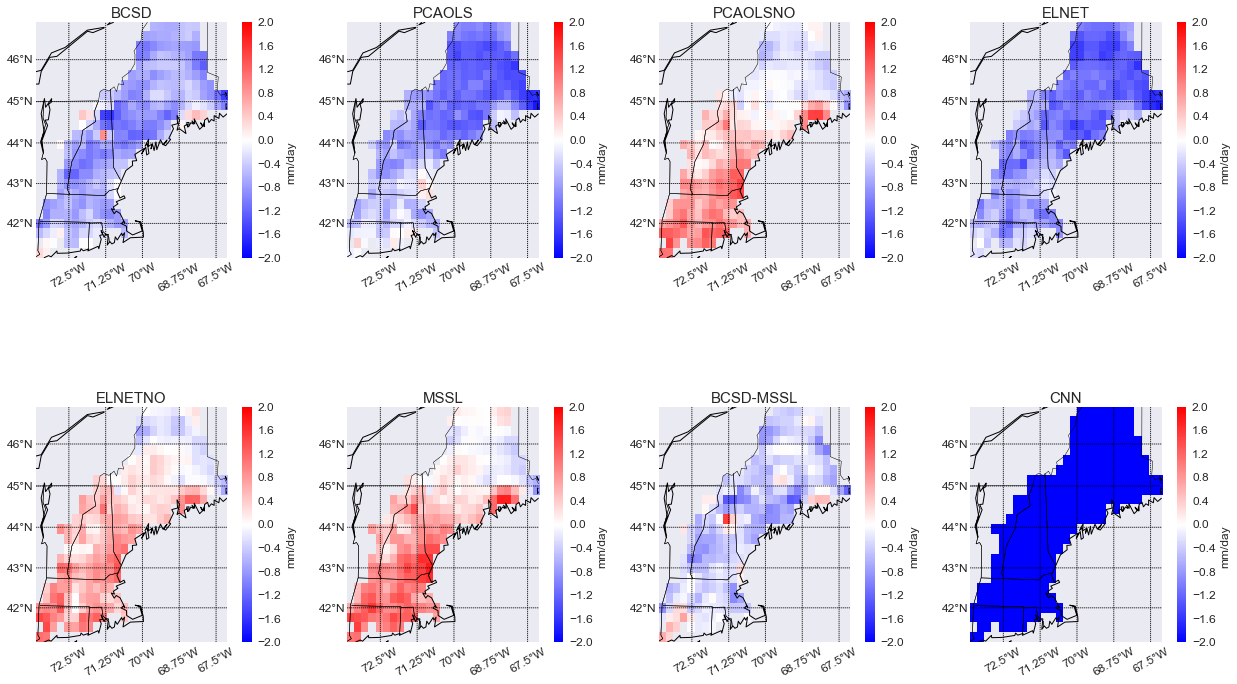

In [313]:
def plot_rmse(dataxray, ax, title='', vmin=None, vmax=None):
    data = dataxray['Bias']
    latcorners = dataxray.lat.values 
    loncorners = dataxray.lon.values #+ 0.25
    lat_0 = latcorners.mean()
    lon_0 = loncorners.mean()

    # create figure and axes instances

    # create polar stereographic Basemap instance.
    m = Basemap(projection='merc', lat_0=lat_0, lon_0=lon_0, \
                llcrnrlat=latcorners[0],urcrnrlat=latcorners[-1],\
                llcrnrlon=loncorners[0],urcrnrlon=loncorners[-1],\
                resolution='l', ax=ax)
    # draw coastlines, state and country boundaries, edge of map.
    m.drawcoastlines()
    m.drawstates()
    m.drawcountries()
    # draw parallels.
    parallels = numpy.arange(0.,90,1.)
    m.drawparallels(parallels,labels=[1,0,0,0],fontsize=12)
    # draw meridians
    meridians = numpy.arange(-180,0.,1.25)
    m.drawmeridians(meridians,labels=[0,0,0,1],fontsize=12, rotation=30)

    ny = data.shape[0]; nx = data.shape[1]
    lons, lats = m.makegrid(nx, ny) # get lat/lons of ny by nx evenly space grid.
    x, y = m(lons, lats) # compute map proj coordinates.
    # draw filled contours.
    #cs = m.contourf(x,y,data,)
    cs = m.imshow(data, interpolation='nearest', cmap='bwr', vmin=vmin, vmax=vmax)
    # add colorbar.
    cbar = m.colorbar(cs,location='right',pad="8%")
    cbar.set_label('mm/day', fontsize=12, horizontalalignment='right')
    # add title
    ax.set_title(title, fontsize=15)
    
fig, axs = pyplot.subplots(2,4, figsize=(18, 12), facecolor='w', edgecolor='k', 
                           sharex=True, sharey=True)
axs = axs.ravel()
for j, key in enumerate(keys):
    dataxray = results_data[key]
    plot_rmse(dataxray, axs[j], title=key, vmin=-2, vmax=2)

pyplot.tight_layout(pad=5.)
pyplot.savefig("figures/BIAS_MAP_%s.eps" % season, dpi=1200)


# RMSE Boxplots

BCSD 8.45157131684
PCAOLS 8.33219859203
PCAOLSNO 8.37027295926
ELNET 7.51519245327
ELNETNO 7.48586831495
MSSL 7.80779193688
BCSD-MSSL 7.86694358252
CNN 9.89119245444


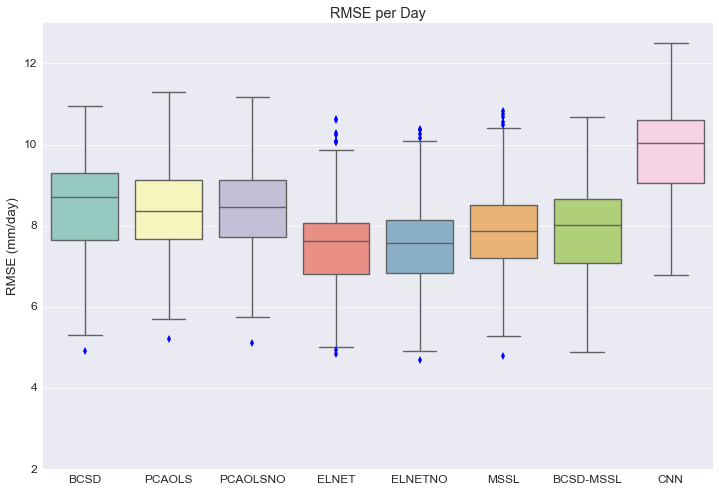

In [314]:
rmse = {}
for j, key in enumerate(keys):
    rmse[key] = results_data[key]['RMSE'].values.flatten()
    print key, numpy.nanmean(results_data[key]['RMSE'].values.flatten())

rmse = pandas.DataFrame(rmse)
pyplot.figure(figsize=(12,8))
seaborn.boxplot(data=rmse, order=keys, palette="Set3")
pyplot.title("RMSE per Day")
pyplot.ylim([2, 13])
pyplot.ylabel("RMSE (mm/day)")
pyplot.savefig("figures/RMSE_Boxplot_%s.eps" % season, dpi=1200)


# Daily Distributions

(0, 100)

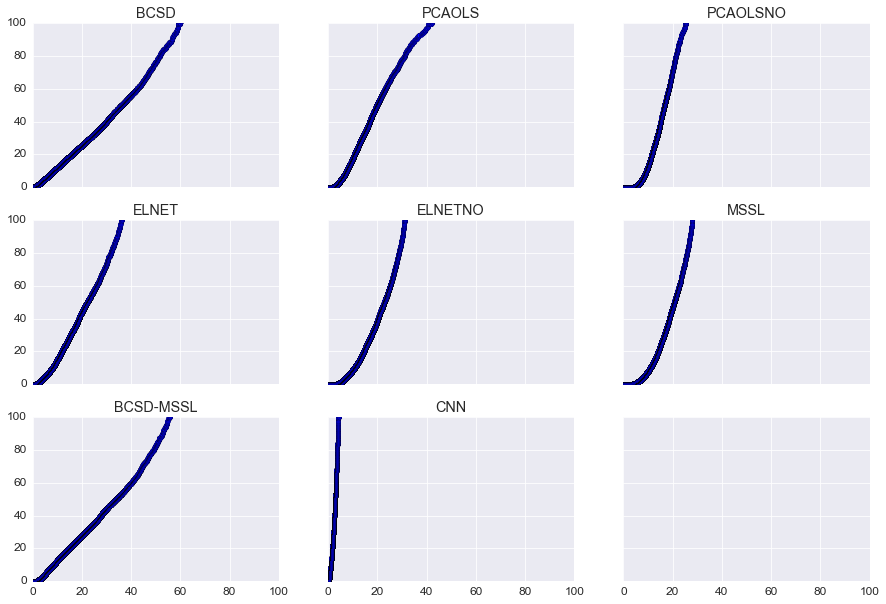

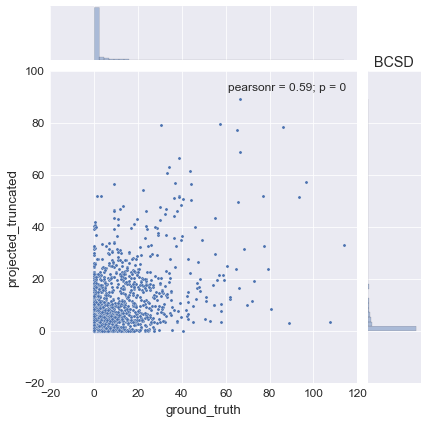

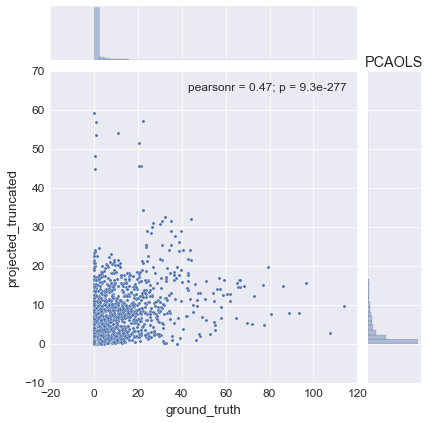

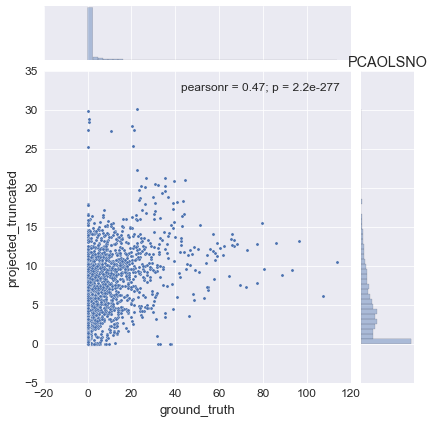

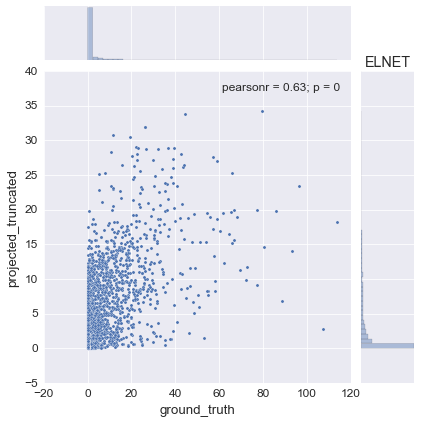

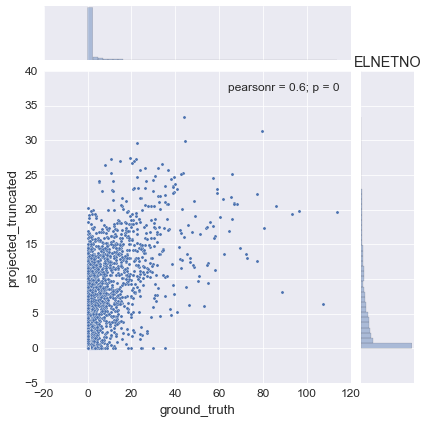

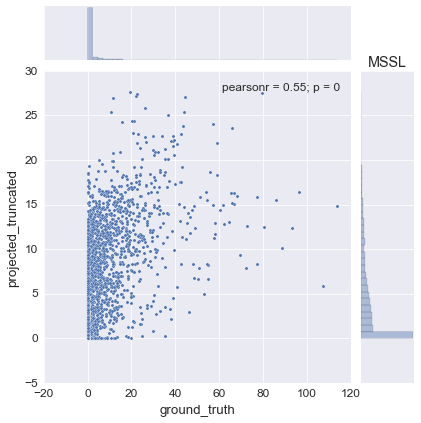

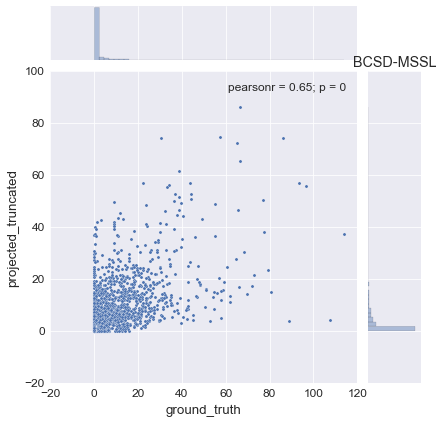

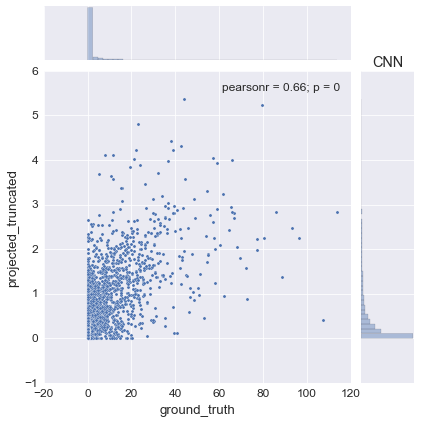

In [315]:
fig, axs = pyplot.subplots(3,3, figsize=(15, 10), facecolor='w', edgecolor='k', sharex=True, sharey=True)

axs = axs.ravel()

def qqplot(x, y, ax=None, **kwargs):
    _, xr = scipy.stats.probplot(x, fit=False)
    _, yr = scipy.stats.probplot(y, fit=False)
    if ax is None:
        pyplot.scatter(xr, yr, **kwargs)
    else:
        ax.scatter(xr, yr, **kwargs)
    
for j, key in enumerate(keys):
    dist = dict(projected=results_data[key].projected.values.flatten(), 
               observed=results_data[key].ground_truth.values.flatten())
    dist = results_data[key].to_dataframe()
    dist.dropna(inplace=True)
    
    dist['projected'][dist.projected < 0] = 0
    axs[j].set_title(key)
    qqplot(dist.projected_truncated, dist.ground_truth, axs[j])

    #seaborn.kdeplot(data=dist.projected_truncated, ax=axs[j])
    #seaborn.kdeplot(data=dist.ground_truth, ax=axs[j])
    #axs[j].set_title(key)
    #axs[j].set_ylim([0, 2100])
    #axs[j].set_xlim([0, 2100])
    #axs[j].set_xlabel("Observed")
    #axs[j].set_ylabel("Downscaled")

    #print key, scipy.stats.ks_2samp(dist['projected_truncated'], dist['ground_truth'])
    #with seaborn.axes_style("white"):
    seaborn.jointplot(x="ground_truth", y="projected_truncated", data=dist.head(5000), 
                          stat_func=scipy.stats.pearsonr, s=10, edgecolor="w")
    pyplot.title(key)


axs[0].set_ylim([0, 100])
axs[0].set_xlim([0, 100])



In [316]:
def xray_correlation(dr1, dr2, axis='time'):
    dr1 = dr1.reindex_like(dr2)
    corrs = []
    for lat in dr1.lat:
        for lon in dr1.lon:
            arr1 = dr1.sel(lat=lat, lon=lon).values
            arr2 = dr2.sel(lat=lat, lon=lon).values
            if numpy.all(numpy.isnan(arr1)) or numpy.all(numpy.isnan(arr2)):
                continue            
            corrs.append(scipy.stats.pearsonr(arr1, arr2)[0])
    
    return numpy.mean(corrs)

def xray_rmse(dr1, dr2, axis='time'):
    rmse = ((dr1 - dr2)**2).mean('time')**0.5
    return rmse
    
def mean_ks(dr1, dr2):
    KSStats = []   
    dr1 = dr1.reindex_like(dr2)
    
    for lat in dr1.lat:
        for lon in dr2.lon:
            arr1 = dr1.sel(lat=lat, lon=lon)
            arr2 = dr2.sel(lat=lat, lon=lon)
            ksstat = scipy.stats.ks_2samp(arr1, arr2)[0]
            KSStats.append(ksstat)
        
    return numpy.mean(KSStats)


def skill_score(x, y, bin_width=1):
    cdfmin = min([numpy.nanmin(x), numpy.nanmin(y)])
    cdfmax = max([numpy.nanmax(x), numpy.nanmax(y)])
    bins = int(1. * (cdfmax - cdfmin) / bin_width)
    xhist =  numpy.histogram(x, bins=bins, range=(cdfmin, cdfmax), density=True)[0]
    yhist =  numpy.histogram(y, bins=bins, range=(cdfmin, cdfmax), density=True)[0]
    concat = numpy.vstack([xhist/xhist.sum(), yhist/yhist.sum()]).T
    return concat.min(axis=1).sum()

def mean_skill_score(dr1, dr2, bin_width=1):
    skills = []   
    dr1 = dr1.reindex_like(dr2)
    
    for lat in dr1.lat:
        for lon in dr2.lon:
            arr1 = dr1.sel(lat=lat, lon=lon).values
            arr2 = dr2.sel(lat=lat, lon=lon).values
            if numpy.all(numpy.isnan(arr1)) or numpy.all(numpy.isnan(arr2)):
                continue      
            sk = skill_score(arr1, arr2, bin_width=bin_width)
            skills.append(sk)
        
    return numpy.mean(skills)

def spatial_distance(latlon):
    dist = []
    for lt1, ln1 in latlon:
        for lt2, ln2 in latlon:
            d = (lt1 - lt2)**2 + (ln1 - ln2)**2
            dist.append(dict(l1=(lt1, ln1), l2=(lt2, ln2), d=d))
    dist = pandas.DataFrame(dist)
    weights = pandas.pivot_table(dist, index="l1", columns="l2", values="d").head()
    
    
def spatial_auto_correlation(dr1, dr2):
    t = 0
    s1 = dr1.isel(time=t).to_series().dropna()
    s2 = dr2.isel(time=t).to_series().dropna()
    s = pandas.concat([s1, s2], axis=1).dropna()
    s.reset_index(inplace=True)
    spatial_distance(s[['lat','lon']].values)
    
spatial_auto_correlation(results_data['BCSD'].ground_truth, results_data['BCSD'].projected_truncated) 


In [317]:
corr_data = []
for seas in ['SON']: #['DJF', 'JJA', 'Annual']:
    for key in keys:
        times = results_data[key]['time'].values
        seasonidxs = numpy.where(results_data[key]['time.season'] == seas)[0]
        if seas == 'Annual':
            dayres = results_data[key]
        else:
            dayres = results_data[key].sel(time=times[seasonidxs])
        daycorr = xray_correlation(dayres.projected_truncated, dayres.ground_truth)
        dayrmse = xray_rmse(dayres.projected_truncated, dayres.ground_truth)/10.
        ks = mean_ks(dayres.projected_truncated, dayres.ground_truth)
        skills = mean_skill_score(dayres.projected_truncated, dayres.ground_truth)
        corr_data.append(dict(season=seas, model=key, Bias=float(dayres.error.mean().values),
                              Correlation=float(daycorr), Skill=skills,
                              RMSE=float(dayrmse.mean().values), KS=ks))
        
        
        
        
corr_data = pandas.DataFrame(corr_data)
corrtable = pandas.pivot_table(corr_data, values='Bias', columns=['season'], index='model')
restable = pandas.pivot_table(corr_data, values=['Bias', 'Correlation', 'RMSE', 'Skill'], 
                              columns=['season'], index='model')


In [318]:
restable = restable.swaplevel(0, 1, axis=1).loc[keys]
print restable
reslatex = restable.to_latex(float_format='{:,.2f}'.format)
open("dailystats.txt", 'w').write(reslatex)

season          SON                                
               Bias Correlation      RMSE     Skill
model                                              
BCSD      -0.633021    0.540816  0.845157  0.903959
PCAOLS    -0.799060    0.543324  0.833220  0.683107
PCAOLSNO   0.325984    0.528251  0.837027  0.517909
ELNET     -0.935624    0.673798  0.751519  0.794423
ELNETNO    0.365906    0.654380  0.748587  0.631261
MSSL       0.511323    0.613050  0.780779  0.597067
BCSD-MSSL -0.340737    0.601041  0.786694  0.755408
CNN       -3.383670    0.693070  0.989119  0.772726


In [230]:


corr_data = []
for seas in seasons:
    for key in keys:
        times = results_data[key]['time'].values
        seasonidxs = numpy.where(results_data[key]['time.season'] == seas)[0]
        dayres = results_data[key].sel(time=times[seasonidxs])
        daycorr = xray_correlation(dayres.projected_truncated, dayres.ground_truth)
        dayrmse = xray_rmse(dayres.projected_truncated, dayres.ground_truth)/10.

        corr_data.append(dict(season=seas, model=key, 
                              correlation=float(daycorr.mean().values),
                              timefreq='Day', RMSE=float(dayrmse.mean().values)))
        
        monthtimes = monthly_results[key]['time'].values
        seasonidxs = numpy.where(monthly_results[key]['time.season'] == seas)[0]
        monthres = monthly_results[key].sel(time=monthtimes[seasonidxs])
        monthcorr = xray_correlation(monthres.projected_truncated, monthres.ground_truth)
        monthrmse = xray_rmse(monthres.projected_truncated, monthres.ground_truth)/10.
        corr_data.append(dict(season=seas, model=key, 
                              correlation=float(monthcorr.mean().values),
                              timefreq='Month', RMSE=float(monthrmse.mean().values)))
        
        
        
        
corr_data = pandas.DataFrame(corr_data)
corrtable = pandas.pivot_table(corr_data, values='correlation', columns=['timefreq', 'season'], index='model')
rmsetable = pandas.pivot_table(corr_data, values='RMSE', columns=['timefreq', 'season'], index='model')
print corrtable

AttributeError: 'numpy.float64' object has no attribute 'values'

# Annual Correlation

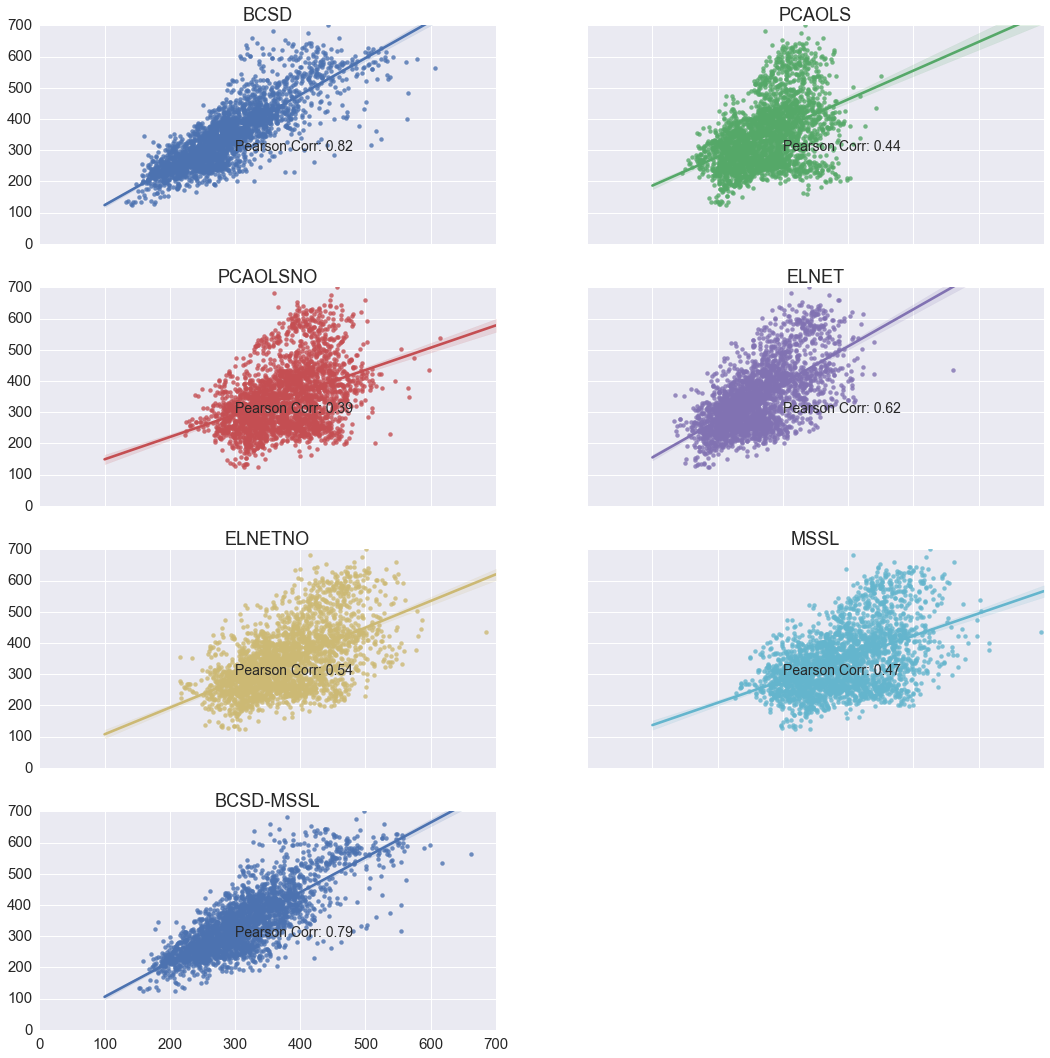

In [319]:
seaborn.set(style="darkgrid", font_scale=1.5)
fig, axs = pyplot.subplots(4,2, figsize=(18, 18), facecolor='w', edgecolor='k', 
                           sharex=True, sharey=True)
axs = axs.ravel()
for j, key in enumerate(keys):
    yearly = {}
    yearly[key] = results_data[key].resample('AS', 'time', how=numpy.sum)
    df = yearly[key].to_dataframe().dropna()
    obs = df.ground_truth.values.flatten()
    proj = df.projected_truncated.values.flatten()
    xylin = numpy.arange(-100, 300, step=1)

    rpear, p = scipy.stats.pearsonr(obs, proj)
    rspear, p = scipy.stats.spearmanr(obs, proj)

    #axs[j].scatter(obs, proj, alpha=0.3)
    
    
    txt = '''Pearson Corr: %0.2f''' % rpear
    
    seaborn.regplot(proj, obs, ax=axs[j])
    axs[j].text(300, 300, txt, fontsize=14)
    axs[j].set_title(key)
    
axs[0].set_xlim([0, 700])
axs[0].set_ylim([0, 700])

fig.delaxes(axs[-1])
pyplot.savefig("figures/annual_correlation.eps")

# Monthly RMSE

In [232]:
seaborn.set(style="darkgrid", font_scale=1.5)
fig = pyplot.figure(figsize=(12,8))
key = 'BCSD'
for key in keys:
    dr = monthly_results[key]
    month_rmse = numpy.zeros(shape=12)
    for m, drm in dr.groupby('time.month'):
        month_rmse[m-1] = xray_rmse(drm.projected_truncated, drm.ground_truth).mean().values
        #break

    pyplot.plot(range(1,13), month_rmse, label=key)
pyplot.xlim([1,12])
pyplot.legend(loc='upper left')
pyplot.title("Monthly Root Mean Square Error (RMSE)")
pyplot.xlabel("Month")
pyplot.ylabel("RMSE (mm/month)")
pyplot.savefig("figures/rmse_timeseries.eps")

NameError: name 'monthly_results' is not defined

# Monthly and Annual Table

Include
1. KS
2. Correlation

In [320]:
key = 'BCSD'
stats = []
for key in keys:
    monthly_dr = results_data[key].resample('MS', 'time', how=numpy.sum)
    monthly = monthly_dr.to_dataframe().dropna()
    yearly_dr = results_data[key].resample('AS', 'time', how=numpy.sum)
    yearly = yearly_dr.to_dataframe().dropna()

    monthcorr = scipy.stats.pearsonr(monthly.projected_truncated.values, monthly.ground_truth.values)[0]
    yearcorr = scipy.stats.pearsonr(yearly.projected_truncated.values, yearly.ground_truth.values)[0]

    #monthKS = scipy.stats.ks_2samp(monthly.projected_truncated.values, monthly.ground_truth.values)[1]
    #yearKS = scipy.stats.ks_2samp(yearly.projected_truncated.values, yearly.ground_truth.values)[1]
    monthskill = skill_score(monthly.projected_truncated.values, monthly.ground_truth.values)
    yearskill = skill_score(yearly.projected_truncated.values, yearly.ground_truth.values, bin_width=100)

    
    monthRMSE = xray_rmse(monthly_dr.projected_truncated, monthly_dr.ground_truth).mean().values
    yearRMSE = xray_rmse(yearly_dr.projected_truncated, yearly_dr.ground_truth).mean().values

    stats.append(dict(model=key, correlation=monthcorr, timefreq='Monthly', Skill=monthskill, RMSE=float(monthRMSE)))
    stats.append(dict(model=key, correlation=yearcorr, timefreq='Yearly', Skill=yearskill, RMSE=float(yearRMSE)))
df = pandas.DataFrame(stats)
df.head()

,RMSE,Skill,correlation,model,timefreq
0,40.190987,0.808270,0.841946,BCSD,Monthly
1,79.364125,0.745802,0.822891,BCSD,Yearly
2,59.372987,0.583459,0.532685,PCAOLS,Monthly
3,114.920230,0.643233,0.440384,PCAOLS,Yearly
4,54.749406,0.622932,0.539581,PCAOLSNO,Monthly


In [321]:
pivoteddf = pandas.pivot_table(df, index='model', values=['correlation', 'Skill', 'RMSE'], columns='timefreq')
pivoteddf.loc[keys].to_csv("part2-table.csv")
reslatex = pivoteddf.loc[keys].to_latex(float_format='{:,.2f}'.format)
open("part2-table.txt", 'w').write(reslatex)
print pivoteddf


                 RMSE                 Skill           correlation          
timefreq      Monthly      Yearly   Monthly    Yearly     Monthly    Yearly
model                                                                      
BCSD        40.190987   79.364125  0.808270  0.745802    0.841946  0.822891
BCSD-MSSL   39.310010   67.142413  0.836036  0.879537    0.808734  0.791719
CNN        118.772405  321.396131  0.042481  0.000000    0.757591  0.625065
ELNET       53.211400  114.885183  0.667043  0.613534    0.742888  0.616026
ELNETNO     46.342027   89.867686  0.755138  0.679699    0.705724  0.541302
MSSL        49.531452   98.905644  0.721053  0.643609    0.664609  0.468008
PCAOLS      59.372987  114.920230  0.583459  0.643233    0.532685  0.440384
PCAOLSNO    54.749406   97.569810  0.622932  0.654135    0.539581  0.392770


# ClimDEX Indicies

In [322]:
def consecutive_wet_days(dr, wet_min=1):
    wd = (dr >= wet_min)
    years = numpy.unique(dr['time.year'].values)
    cwd = []
    for y in years:
        cond = wd.sel(time=wd['time.year'] == y).values
        consec = numpy.max([sum( 1 for _ in group ) for key, group in itertools.groupby(cond) if key])
        cwd.append(consec)

    return xray.DataArray(numpy.array(cwd)[:, numpy.newaxis, numpy.newaxis], 
                          coords=[years, [dr.lat.values], [dr.lon.values]], 
                          dims=['time', 'lat', 'lon'])

def wet_days(dr, wet_min=20):
    wd = dr >= wet_min
    return wd.resample('AS', 'time', how='sum')

def consecutive_max(dr, days=5):
    rollsum = pandas.rolling_sum(dr.to_pandas(), 5) 
    drsum = xray.DataArray.from_series(rollsum).resample('MS', 'time', how='max')
    return xray.DataArray(drsum.values[:, numpy.newaxis, numpy.newaxis], 
                          coords=[drsum.time.values, [dr.lat.values], [dr.lon.values]], 
                          dims=['time', 'lat', 'lon'])
    
def daily_intensity_index(dr, wet_min=1):
    wd = (dr >= wet_min).resample('AS', 'time', how='sum')
    precip = dr.resample('AS', 'time', how='sum')
    return precip / wd

def merge_datarrays(dr_list):
    dfs = [d.to_series() for d in dr_list]
    ds = xray.DataArray.from_series(pandas.concat(dfs))
    return ds
    
def get_climdex(dr):
    SDI = daily_intensity_index(dr)
    R20 = wet_days(dr)
    cwd = []
    rx5 = []
    for lt in dr.lat:
        for ln in dr.lon:
            dtemp = dr.sel(lat=lt, lon=ln)
            dtemp = dtemp.dropna('time')
            if dtemp.shape[0] == 0:
                continue
            cwd += [consecutive_wet_days(dtemp)]
            rx5 += [consecutive_max(dtemp)]
    return dict(CWD=merge_datarrays(cwd), RX5day=merge_datarrays(rx5),
               SDII=SDI, R20=R20)

dr1 = results_data['BCSD'].projected_truncated
dr2 = results_data['BCSD'].ground_truth

obs_climdex = get_climdex(results_data['BCSD'].ground_truth)

var = keys[0]
varclimdex = get_climdex(results_data[var].projected_truncated)


In [323]:
climdex_res = []
for var in keys:
    varclimdex = get_climdex(results_data[var].projected_truncated)
    for metric in varclimdex:
        ds = xray.Dataset(dict(x=obs_climdex[metric], y=varclimdex[metric]))
        df = ds.to_dataframe().dropna(how='any')
        cor = scipy.stats.pearsonr(df.x, df.y)[0]
        climdex_res += [dict(model=var, metric=metric, corr=cor)]
        
        
        

In [324]:
climdex_df = pandas.DataFrame(climdex_res)
climdex_df.pivot('model', 'metric').loc[keys]
reslatex = climdex_df.pivot('model', 'metric').loc[keys].to_latex(float_format='{:,.2f}'.format)
open("climdex.txt", 'w').write(reslatex)
print reslatex


\begin{tabular}{lrrrr}
\toprule
{} & corr &      &        &       \\
metric &  CWD &  R20 & RX5day &  SDII \\
\midrule
model     &      &      &        &       \\
BCSD      & 0.45 & 0.80 &   0.68 &  0.64 \\
PCAOLS    & 0.20 & 0.55 &   0.17 &  0.49 \\
PCAOLSNO  & 0.08 & 0.28 &   0.25 &  0.45 \\
ELNET     & 0.17 & 0.66 &   0.53 &  0.59 \\
ELNETNO   & 0.12 & 0.69 &   0.56 &  0.53 \\
MSSL      & 0.23 & 0.53 &   0.49 &  0.46 \\
BCSD-MSSL & 0.21 & 0.78 &   0.63 &  0.62 \\
CNN       & 0.32 &  nan &   0.69 & -0.32 \\
\bottomrule
\end{tabular}



# SDI Figure

In [325]:
sdi_ts = dict(obs=obs_climdex['SDII'].mean(['lat', 'lon']).values)
for var in keys:
    varclimdex = get_climdex(results_data[var].projected_truncated)
    sdi_ts[var] = varclimdex['SDII'].mean(['lat', 'lon']).values
    
    
    

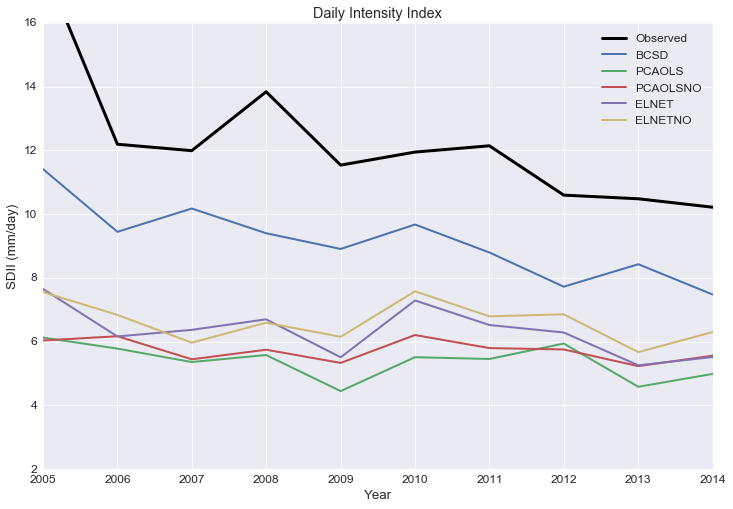

In [328]:
seaborn.set_context("paper",  font_scale=1.5)
years = [datetime.datetime(year=y, month=1, day=1) for y in range(2005, 2015)]
pyplot.figure(figsize=(12,8))
pyplot.plot(years, sdi_ts['obs'], color='black', label="Observed", lw=3)
keys = ['BCSD', 'PCAOLS', 'PCAOLSNO', 'ELNET', 'ELNETNO']
for k in keys:
    pyplot.plot(years, sdi_ts[k], label=k, lw=2)
pyplot.ylim([2,16])
pyplot.title("Daily Intensity Index")
pyplot.ylabel("SDII (mm/day)")
pyplot.xlabel("Year")
pyplot.legend()
pyplot.savefig("figures/sdii.eps")

PCAOLS 5.10703693583
PCAOLSLOG 4.09105441939


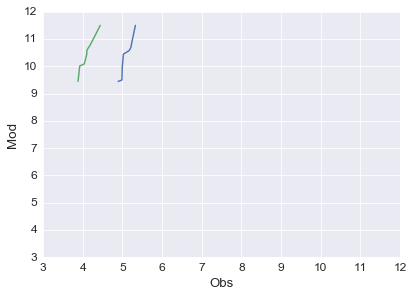

In [240]:
def qqplot_line(x, y, ax=None, **kwargs):
    _, xr = scipy.stats.probplot(x, fit=False)
    _, yr = scipy.stats.probplot(y, fit=False)
    if ax is None:
        pyplot.plot(xr, yr, **kwargs)
    else:
        ax.plot(xr, yr, **kwargs)
    

#for k in keys:
for k in ['PCAOLS', 'PCAOLSLOG']:
    print k, sdi_ts[k].mean()
    qqplot_line(sdi_ts[k], sdi_ts['obs'])
pyplot.xlim([3,12])
pyplot.ylim([3,12])
pyplot.xlabel('Obs')
pyplot.ylabel('Mod')


In [164]:
for var in keys:
    varclimdex = get_climdex(results_data[var].projected_truncated)
    for metric in varclimdex:
        ds = xray.Dataset(dict(x=obs_climdex[metric], y=varclimdex[metric]))
        df = ds.to_dataframe().dropna(how='any')
        cor = scipy.stats.pearsonr(df.x, df.y)[0]
        climdex_dist += [dict(model=var, metric=metric, mu=df.y.mean())]

In [167]:
climdex_df = pandas.DataFrame(climdex_dist)
climdex_df.pivot('model', 'metric').loc[keys]
reslatex = climdex_df.pivot('model', 'metric').loc[keys].to_latex(float_format='{:,.2f}'.format)
open("climdex-dist.txt", 'w').write(reslatex)


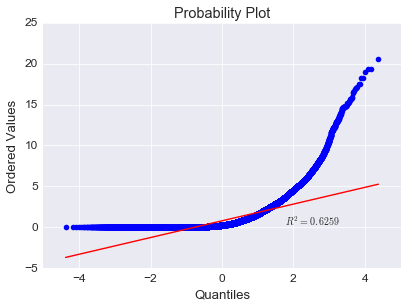

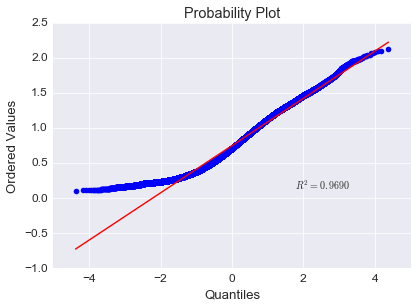

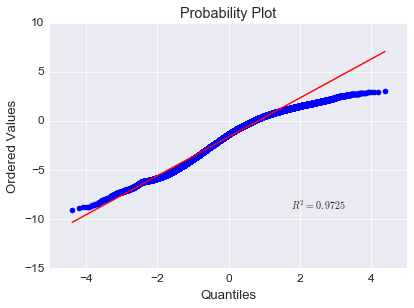

In [286]:
obs = results_data['BCSD'].ground_truth.to_series().dropna()
obs = obs[obs > 0]
ax1 = pyplot.subplot(111)
scipy.stats.probplot(obs.values**1., plot=ax1, dist=scipy.stats.norm)
pyplot.show()

ax1 = pyplot.subplot(111)
scipy.stats.probplot(obs.values**.25, plot=ax1, dist=scipy.stats.norm)
pyplot.show()

ax1 = pyplot.subplot(111)
scipy.stats.probplot(numpy.log(obs.values+1e-10), plot=ax1, dist=scipy.stats.norm)
pyplot.show()



In [195]:
scipy.stats.boxcox(obs[obs > 0].values)

(array([-2.35668184,  2.919893  , -1.14177039, ...,  2.3607607 ,
         0.74062988,  0.20704564]), 0.1143653383291343)

0.814853191541


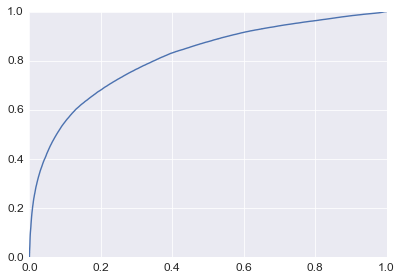

In [357]:
from sklearn.metrics import roc_auc_score, roc_curve

k = 'PCAOLS'
pred = results_data[k]['occurance'].to_dataframe().dropna()
occur = (results_data[k]['ground_truth'] >= 0.5).to_dataframe()
r = pred.join(occur)

print roc_auc_score(r['ground_truth'], r['occurance'])
fpr, tpr, thresholds = roc_curve(r['ground_truth'], r['occurance'])
pyplot.plot(fpr, tpr)
